In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth


    auth.authenticate_user()

In [2]:
! gsutil -m cp -r gs://github-repo/distillation/* .

Copying gs://github-repo/distillation/requirements.txt...
Copying gs://github-repo/distillation/PaLM_CoT_train.json...
Copying gs://github-repo/distillation/PaLM_CoT_test.json...
Copying gs://github-repo/distillation/prediction_container/Dockerfile...
Copying gs://github-repo/distillation/prediction_container/app/main.py...
Copying gs://github-repo/distillation/prediction_container/app/prestart.sh...
Copying gs://github-repo/distillation/prediction_container/app/requirements.txt...
Copying gs://github-repo/distillation/prediction_container/app/requirements-torch.txt...


In [3]:
! pip install -r requirements.txt

# Step 1: Data Preparation

Our dataset will need three fields:
1. An input message for the LLM
2. A fundamental truth label, which is the expected outcome
3. A 'reasoning', which is the reasoning generated by the teacher model (using the CoT message)

Here, I am using the Hugging Face dataset [Common Sense Explanations](https://huggingface.co/datasets/cos_e) to train our student model. This dataset contains approximately 10,000 training samples and 1,200 test samples.

In this case, we will use a model that doesn't require a token in Hugging Face; we will use a public model without restrictions. I can ignore the warning for now. The code will continue to work.

I am using wandb to track and visualize training metrics.
The Seq2SeqTrainer from HuggingFace integrated with wandb
when it's available in the environment, allowing us to monitor:
Training/validation loss curves,
Accuracy metrics over time,
Learning rate schedules &
GPU/memory utilization.


In [4]:
from huggingface_hub import login

In [5]:
from typing import Any

from datasets import DatasetDict, load_dataset

In [6]:
SOURCE_DATASET = "cos_e"  # @param {type:"string"}
SOURCE_DATASET_VERSION = "v1.11"  # @param {type:"string"}

dataset = load_dataset(SOURCE_DATASET, SOURCE_DATASET_VERSION)
dataset["test"] = dataset["validation"]
del dataset["validation"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

v1.11/train-00000-of-00001.parquet:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

v1.11/validation-00000-of-00001.parquet:   0%|          | 0.00/222k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'choices', 'answer', 'abstractive_explanation', 'extractive_explanation'],
        num_rows: 9741
    })
    test: Dataset({
        features: ['id', 'question', 'choices', 'answer', 'abstractive_explanation', 'extractive_explanation'],
        num_rows: 1221
    })
})

In [8]:
def prepare_input(example: dict[str, Any]) -> dict[str, Any]:
    question = example["question"]
    c_0 = example["choices"][0]
    c_1 = example["choices"][1]
    c_2 = example["choices"][2]
    c_3 = example["choices"][3]
    c_4 = example["choices"][4]

    input = f"{question}\nAnswer Choices:\n(a) {c_0}\n(b) {c_1}\n(c) {c_2}\n(d) {c_3}\n(e) {c_4}"

    example["input"] = input
    example["label"] = example["answer"]

    return example


dataset = dataset.map(
    prepare_input,
    remove_columns=[
        "id",
        "question",
        "choices",
        "answer",
        "abstractive_explanation",
        "extractive_explanation",
    ],
)

Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [9]:
dataset['train']['input']

Column(['"There are 10 apples on an apple tree.  Three fall off.  Now there are X apples."  What is this an example of?\nAnswer Choices:\n(a) park\n(b) coloring book\n(c) garden center\n(d) math problem\n(e) gravity', 'A John is a bum.  Much like the stereotype, he lives near this sort of transportation infrastructure. Where does he live?\nAnswer Choices:\n(a) bus depot\n(b) beach\n(c) train station\n(d) bridge\n(e) bridge', 'A bad person places little value on being honest, acting without pretense or being what?\nAnswer Choices:\n(a) excellent\n(b) upright\n(c) premium\n(d) competent\n(e) sincere', 'A bald eagle flies over St. Paul, where is it?\nAnswer Choices:\n(a) texas\n(b) thermal\n(c) minnesota\n(d) canada\n(e) photograph', 'A battleship is a powerful vessel.  If you need something similar but faster, what would you use?\nAnswer Choices:\n(a) yatch\n(b) corvette\n(c) aircraft carrier\n(d) destroyer\n(e) patrol boat'])

On the other hand, there are the results generated by the PaLM model (LLM model). These results are typically stored in a JSON file and can contain inputs, predicted labels, and rationale (the reasoning behind the predictions).

The PaLM (Pathways Language Model) is used as a master model.

In [10]:
LLM_OUTPUTS_FILE_PREFIX = "PaLM_CoT"  # @param {type:"string"}
LLM_OUTPUTS_FILE = LLM_OUTPUTS_FILE_PREFIX + "_{split}.json"


def add_llm_outputs(dataset: DatasetDict, split: str) -> None:
    llm_ds = load_dataset("json", data_files=LLM_OUTPUTS_FILE.format(split=split))[
        "train"
    ]

    print(llm_ds)

    def _add(example: dict[str, Any], idx: int) -> dict[str, Any]:
        example["llm_rationale"] = llm_ds[idx]["rationale"]
        example["llm_label"] = llm_ds[idx]["label"]
        return example

    dataset[split] = dataset[split].map(_add, with_indices=True)


for split in ["train", "test"]:
    add_llm_outputs(dataset, split)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['rationale', 'label'],
    num_rows: 9741
})


Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['rationale', 'label'],
    num_rows: 1221
})


Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'label', 'llm_rationale', 'llm_label'],
        num_rows: 9741
    })
    test: Dataset({
        features: ['input', 'label', 'llm_rationale', 'llm_label'],
        num_rows: 1221
    })
})

In [12]:
dataset['train']['label']

Column(['math problem', 'bridge', 'sincere', 'minnesota', 'corvette'])

# Step 2: Build the student model

In [13]:
import pandas as pd
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
)

Here, I will use the T5 model as a pre-trained base for distillation, and we'll use the corresponding tokenizer. We can use a different pre-trained model (and corresponding tokenizer) by renaming the model below to a different model in Hugging Face or we can use a custom model/train a tokenizer from scratch on our own dataset. Keep in mind that I will need significantly more data and computation to train a good model from scratch.

T5 is available in multiple sizes, including: T5 Small, T5 Base, T5 Large, T5 3B, and T5 11B.

In [14]:
PRETRAINED_BASE_MODEL = "google/flan-t5-base"  # @param {type:"string"}
MAX_INPUT_LENGTH = 1024  # @param {type:"integer"} ## tokens
MAX_OUTPUT_LENGTH = 256  # @param {type:"integer"} ## tokens

In [15]:
PRETRAINED_BASE_MODEL

'google/flan-t5-base'

## a) Prepare the tokenizer and tokenize the dataset.

The provided code snippet defines a function to tokenize the dataset using Hugging Face tokenizer for the specified pre-trained model (in this case, google/flan-t5-base).

This line initializes the tokenizer for the previously specified trained model. It will handle converting the text inputs into a format suitable for the model (tokens).

In [16]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_BASE_MODEL)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [17]:
def tokenize_function(examples: dict[str, list[Any]]):

    ''' The function creates model inputs by prefixing each input text with the phrase "predict:".
It uses the tokenizer to encode these modified inputs into token identifiers,
limiting the length to MAX_INPUT_LENGTH and truncating any text that exceeds this length.'''

    model_inputs = tokenizer(
        ["predict: " + text for text in examples["input"]],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )

    '''
    Similarly, this part creates entries for the explain task by prefixing each input text with "explain:".
It encodes these entries using the same tokenization process as before.
    '''
    expl_model_inputs = tokenizer(
        ["explain: " + text for text in examples["input"]],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )

    '''
    For an input sentence like "predict: What is the capital of France?",
the tokenizer converts this sentence into input_ids as follows:
[101, 12345, 456, 7890, 2345, 678, 1234, 2345]
    '''

    '''
    The attention mask is a binary tensor that indicates which tokens the model should attend to (process) and which it should ignore (e.g., padding tokens). It helps the model differentiate between real and padding tokens.
For the same input sentence, if the tokenizer adds padding to ensure that the input length is consistent, the attention mask might look like this:
[1,0,0,1,0,1]
    '''
    model_inputs["expl_input_ids"] = expl_model_inputs["input_ids"]
    model_inputs["expl_attention_mask"] = expl_model_inputs["attention_mask"]

    # Encode the destination label and destination justification
    label_output_encodings = tokenizer(
        text_target=examples["label"], max_length=MAX_OUTPUT_LENGTH, truncation=True
    )

    rationale_output_encodings = tokenizer(
        text_target=examples["llm_rationale"],
        max_length=MAX_OUTPUT_LENGTH,
        truncation=True,
    )

    model_inputs["labels"] = label_output_encodings["input_ids"]
    model_inputs["expl_labels"] = rationale_output_encodings["input_ids"]

    return model_inputs


tokenized_dataset = dataset.map(
    tokenize_function,
    remove_columns=["input", "llm_rationale", "label", "llm_label"],
    batched=True,
)

Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [18]:
tokenized_dataset['train']['expl_labels']

Column([[37, 1525, 398, 36, 424, 24, 65, 12, 103, 28, 8, 756, 682, 5, 1129, 8, 756, 3703, 6, 163, 7270, 682, 65, 12, 103, 28, 8, 756, 682, 5, 1], [37, 1525, 398, 36, 3, 9, 286, 213, 3, 9, 8524, 51, 133, 619, 5, 1129, 8, 756, 3703, 6, 163, 3, 9, 2412, 2478, 19, 3, 9, 286, 213, 3, 9, 8524, 51, 133, 619, 5, 1], [37, 1525, 398, 36, 3, 9, 1448, 24, 8788, 3, 9, 207, 568, 5, 1129, 8, 756, 3703, 6, 163, 437, 60, 8788, 3, 9, 207, 568, 5, 1], [37, 1525, 398, 36, 3, 9, 286, 213, 3, 8267, 3, 15, 9, 3537, 7, 3971, 5, 1129, 8, 756, 3703, 6, 163, 9745, 65, 3, 8267, 3, 15, 9, 3537, 7, 5, 1], [37, 1525, 398, 36, 3, 9, 1006, 11, 2021, 12662, 5, 1129, 8, 756, 3703, 6, 163, 10123, 277, 33, 1006, 11, 2021, 5, 1]])

In [19]:
tokenized_dataset['train']['labels']

Column([[7270, 682, 1], [4716, 1], [437, 60, 1], [3519, 1496, 32, 17, 9, 1], [4301, 19828, 1]])

## b) Prepare the student model

In [20]:
model = AutoModelForSeq2SeqLM.from_pretrained(PRETRAINED_BASE_MODEL)
#GPU to enable parallelism
model.parallelize()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

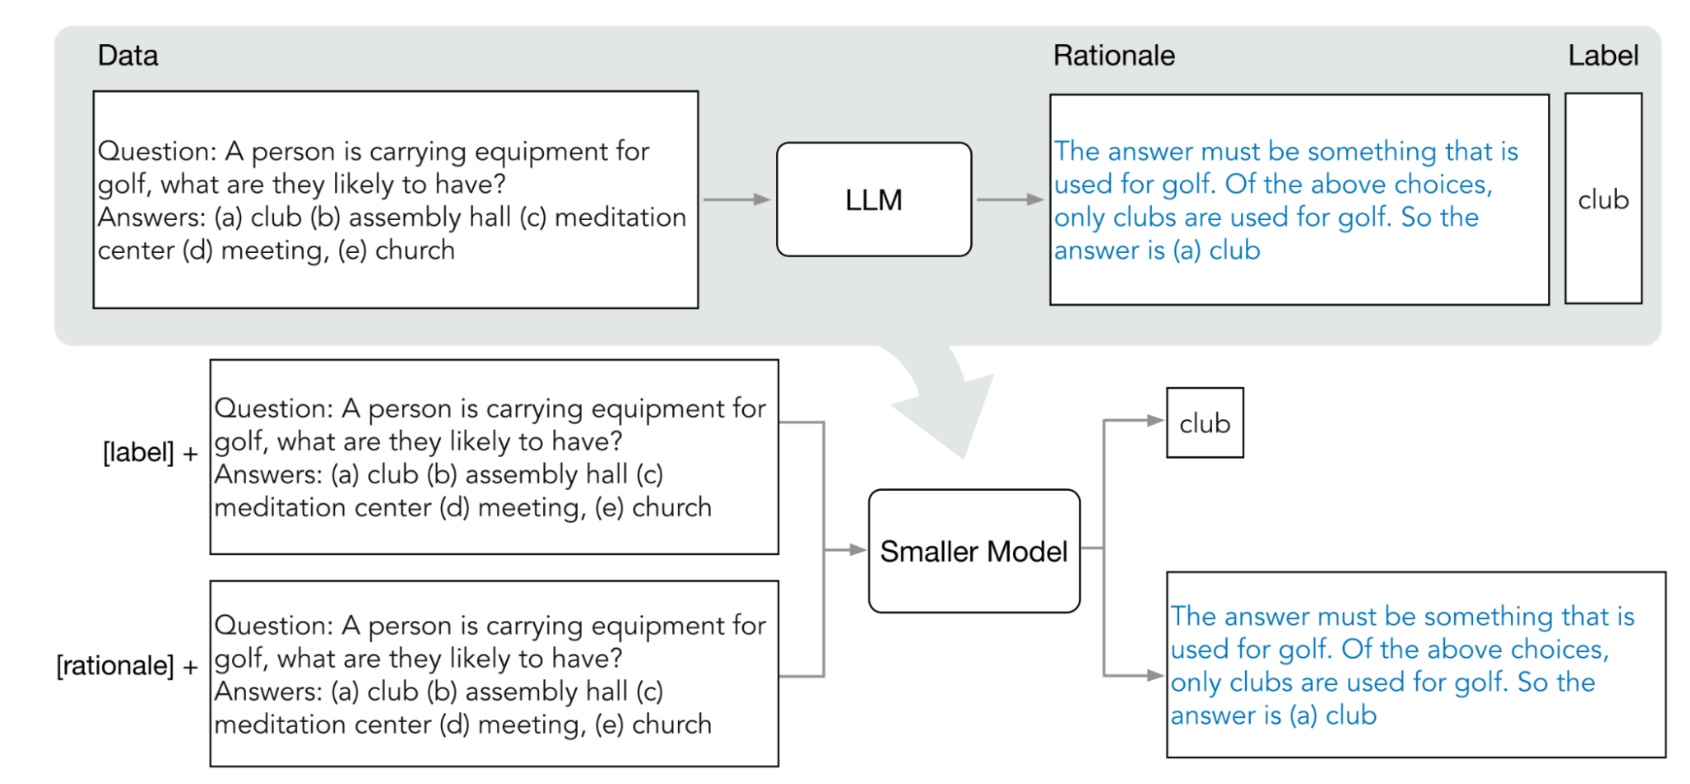

## c) Prepare the data collector for multitasking training
Since we need to generate predictions for both the response and the rationale at each training and prediction step, we will use a custom data collector that will take each batch of features and return two sets of features and labels, one for the response and one for the rationale.

In [21]:
class TaskPrefixDataCollator(DataCollatorForSeq2Seq):
    def __call__(self, features, return_tensors=None):
        features_df = pd.DataFrame(features)
        '''
        The code extracts relevant columns for the response features (labels, input_ids, attention_mask) and converts them back to a dictionary format using `to_dict("records").`
Since the model will be receiving two inputs, to avoid using another mapping, only the explanatory features are renamed.
        '''
        # Generate functions for responses
        ans_features = features_df.loc[
            :, features_df.columns.isin(["labels", "input_ids", "attention_mask"])
        ].to_dict("records")
        ans_features = super().__call__(ans_features, return_tensors)

        # Generate features for explanations
        expl_features = (
            features_df.loc[
                :,
                features_df.columns.isin(
                    ["expl_labels", "expl_input_ids", "expl_attention_mask"]
                ),
            ]
            .rename(
                columns={
                    "expl_labels": "labels",
                    "expl_input_ids": "input_ids",
                    "expl_attention_mask": "attention_mask",
                }
            )
            .to_dict("records")
        )
        expl_features = super().__call__(expl_features, return_tensors)

        return {
            "ans": ans_features,
            "expl": expl_features,
        }


data_collator = TaskPrefixDataCollator(tokenizer=tokenizer, model=model)

The loss function is:

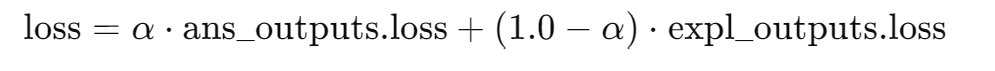

In [22]:
class TaskPrefixTrainer(Seq2SeqTrainer):
    def __init__(self, alpha, output_rationale, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.output_rationale = output_rationale

    def compute_loss(self, model, inputs,num_items_in_batch=None, return_outputs=False):
        ans_outputs = model(**inputs["ans"])
        expl_outputs = model(**inputs["expl"])

        loss = self.alpha * ans_outputs.loss + (1.0 - self.alpha) * expl_outputs.loss

        return (
            (loss, {"ans": ans_outputs, "expl": expl_outputs})
            if return_outputs
            else loss
        )

#### We can use it manually. *** If we are creating our own trainer, it is necessary to use it.
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        ans_outputs = super().prediction_step(
            model, inputs["ans"], prediction_loss_only=False, ignore_keys=ignore_keys
        )
        if self.output_rationale:
            expl_outputs = super().prediction_step(
                model,
                inputs["expl"],
                prediction_loss_only=False,
                ignore_keys=ignore_keys,
            )
        else:
            expl_outputs = ans_outputs  # placeholder only

        loss = self.alpha * ans_outputs[0] + (1 - self.alpha) * expl_outputs[0]

        return (
            loss,
            [ans_outputs[1], expl_outputs[1]],
            [ans_outputs[2], expl_outputs[2]],
        )

# Step 3: Train the model

In [23]:
import numpy as np
from transformers import Seq2SeqTrainingArguments
from transformers.trainer_utils import set_seed

In [24]:
RUN_ID = 0  # @param {type:"integer"}
CONFIG_DIR = "distillation_outputs"  # @param {type:"string"}
CKPT_DIR = f"{CONFIG_DIR}/ckpts/{RUN_ID}"  # for model checkpoints
LOG_DIR = f"{CONFIG_DIR}/logs/{RUN_ID}"  # for training logs

EVAL_STEPS = 500  # @param {type:"integer"}
SAVE_STEPS = 1000  # @param {type:"integer"}
MAX_STEPS = 4000  # @param {type:"integer"}


LEARNING_RATE = 5e-5
BATCH_SIZE = 16

ALPHA = 0.7 ### The hyper-parameter of the relative contribution of my predictions (labels + explanation-rh)

In [25]:
set_seed(RUN_ID)

training_args = Seq2SeqTrainingArguments(
    CKPT_DIR,
    remove_unused_columns=False,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    logging_dir=LOG_DIR,
    logging_strategy="steps",
    logging_steps=EVAL_STEPS,
    max_steps=MAX_STEPS,
    learning_rate=LEARNING_RATE,
    gradient_accumulation_steps=1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    seed=RUN_ID,
    local_rank=-1,
    bf16=False,
    generation_max_length=64,
    prediction_loss_only=False,
)

In [26]:
from collections.abc import Callable

from transformers import AutoTokenizer

def compute_metrics_text(tokenizer: AutoTokenizer) -> Callable:
    def compute_metrics(eval_pred: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
        predictions, labels = eval_pred
        decoded_preds = tokenizer.batch_decode(predictions[0], skip_special_tokens=True)

        labels = np.where(labels[0] != -100, labels[0], tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        acc = np.mean(np.array(decoded_preds) == np.array(decoded_labels))

        return {"accuracy": acc}

    return compute_metrics


compute_metrics = compute_metrics_text(tokenizer)

In [27]:
trainer_kwargs = {
    "alpha": ALPHA,
    "output_rationale": False,
    "model": model,
    "args": training_args,
    "train_dataset": tokenized_dataset["train"],
    "eval_dataset": {
        "test": tokenized_dataset["test"],
    },
    "data_collator": data_collator,
    "tokenizer": tokenizer,
    "compute_metrics": compute_metrics,
}

# Wandb API key


In [28]:
trainer = TaskPrefixTrainer(**trainer_kwargs)
trainer.train()

/tmp/ipython-input-2640670292.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `TaskPrefixTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: diego-alonso-luna-ramirez (diego-alonso-luna-ramirez-tecnol-gico-de-monterrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Test Loss,Test Accuracy
500,0.470200,No log,0.362570,0.732187
1000,0.351300,No log,0.376921,0.722359
1500,0.306700,No log,0.413716,0.722359
2000,0.271800,No log,0.444275,0.729730
2500,0.251300,No log,0.421733,0.742834
3000,0.232200,No log,0.450997,0.741196
3500,0.215800,No log,0.476236,0.733006
4000,0.209400,No log,0.459887,0.730549


TrainOutput(global_step=4000, training_loss=0.2885858879089355, metrics={'train_runtime': 3462.5554, 'train_samples_per_second': 18.483, 'train_steps_per_second': 1.155, 'total_flos': 0.0, 'train_loss': 0.2885858879089355, 'epoch': 6.568144499178982})

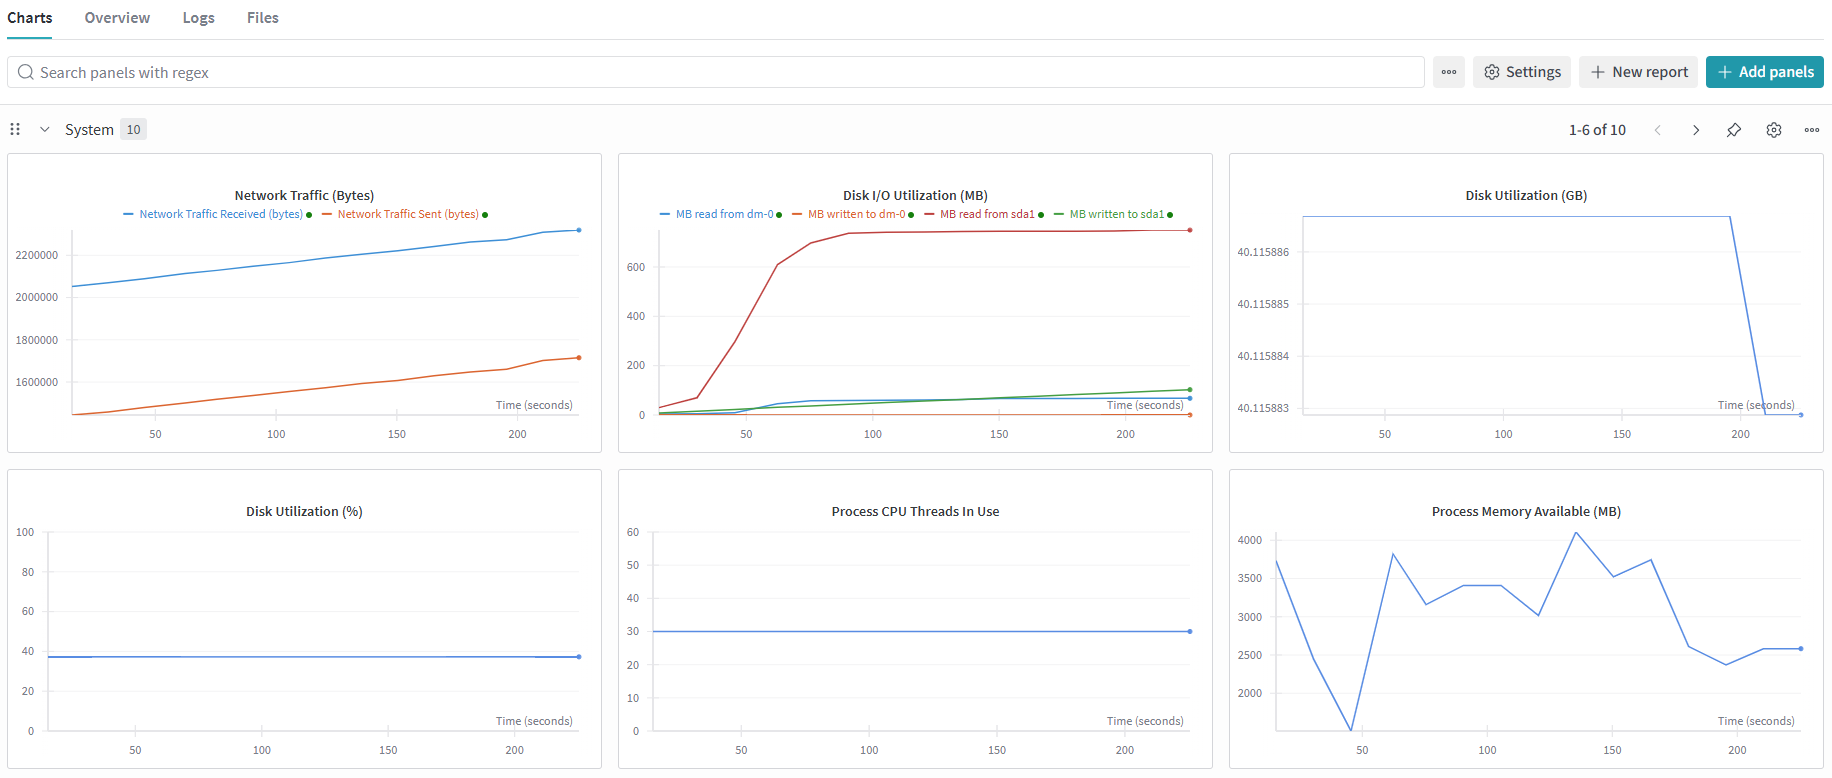

# Step 4: Evaluate the model

Now let's compare the performance of our simplified student model with that of the PaLM model. We will also try to generate results from the base student model to compare the difference achieved by the simplified training method.

In [29]:
from transformers import pipeline

In [30]:
CHECKPOINT = f"{CKPT_DIR}/checkpoint-4000"

distilled_tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
distilled_model = AutoModelForSeq2SeqLM.from_pretrained(CHECKPOINT)

base_tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_BASE_MODEL)
base_model = AutoModelForSeq2SeqLM.from_pretrained(PRETRAINED_BASE_MODEL)

In [34]:
distill_generator = pipeline(
    "text2text-generation", model=distilled_model, tokenizer=distilled_tokenizer
)
base_generator = pipeline(
    "text2text-generation", model=base_model, tokenizer=base_tokenizer
)


def generate_answers(sample: dict[str, Any]) -> dict[str, Any]:
    sample["distill_label"] = distill_generator(["predict: " + sample["input"]])[0][
        "generated_text"
    ]
    sample["base_label"] = base_generator(sample["input"])[0]["generated_text"]
    return sample


output_dataset = dataset["test"].map(generate_answers)

Device set to use cuda:0
Device set to use cuda:0


Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [35]:
output_df = output_dataset.to_pandas().drop("llm_rationale", axis=1)
display_df = output_df.copy().rename(
    columns={
        "input": "Question",
        "label": "True answer",
        "llm_label": "PaLM answer",
        "base_label": "T5 answer",
        "distill_label": "Distilled T5 answer",
    }
)
display_df.head(10)

,Question,True answer,PaLM answer,Distilled T5 answer,T5 answer
0,"A beaver is know for building prowess, their s...",wooded area,wooded area,wooded area,(c)
1,A car was hailed to chauffeur someone to the o...,go downtown,go downtown,go downtown,(a)
2,"A child wants to play, what would they likely ...",play tag,play tag,play tag,(c)
3,"A farmer sees a weasel in the woods, where is ...",great outdoors,great outdoors,great outdoors,(d)
4,"A gentleman is carrying equipment for golf, wh...",club,club,club,(a)
5,"A human wants to submerge himself in water, wh...",whirlpool bath,whirlpool bath,whirlpool bath,(a)
6,"A loud machine is irritating, but many are exp...",industrial area,industrial area,laboratory,(e)
7,A man takes a seat at a museum outside of Barc...,martorell,show,martorell,(b)
8,A man wants air conditioning while we watches ...,house,house,movie theatre,(e)
9,A patriotic guy with a camera is looking for a...,photograph,photograph,photograph,(e)


##Results

In [36]:
print(
    "The accuracy of PaLM model is {:.2f}%".format(
        output_df[output_df["label"] == output_df["llm_label"]]["label"].count()
        / len(output_df)
        * 100
    )
)
print(
    "The accuracy of raw student model is {:.2f}%".format(
        output_df[output_df["label"] == output_df["base_label"]]["label"].count()
        / len(output_df)
        * 100
    )
)
print(
    "The accuracy of distilled student model is {:.2f}%".format(
        output_df[output_df["label"] == output_df["distill_label"]]["label"].count()
        / len(output_df)
        * 100
    )
)

The accuracy of PaLM model is 77.23%
The accuracy of raw student model is 0.25%
The accuracy of distilled student model is 73.30%


##Conclusion

The experiments clearly demonstrate the effectiveness of knowledge distillation in compressing large language model capabilities into a smaller, more efficient architecture. The pre-trained T5 student initially performed at near-random levels, failing to generate coherent or task relevant outputs. After distillation, however, the model achieved a substantial recovery in reasoning accuracy and response quality, closely approximating the performance of its teacher while requiring far fewer computational resources.

This outcome validates the central premise of knowledge distillation: that structured transfer of soft label information allows smaller models to internalize the reasoning behavior of larger ones, rather than merely replicating their outputs. Even under constrained data and compute conditions, the distilled model demonstrated strong generalization and stability, confirming that efficiency and intelligence can coexist when the learning process is properly guided.

The current implementation serves as a solid baseline, with clear potential for refinement through extended training, hyperparameter tuning, or expanded datasets. Future iterations could further reduce the remaining performance gap and adapt the approach to more complex reasoning domains.

In practical terms, these results highlight knowledge distillation as a scalable strategy for deploying capable, cost-efficient models in production environments. It provides a pathway to preserve the interpretive and decision-making depth of large LLMs while ensuring accessibility across diverse computational settings.

Knowledge distillation transforms model compression into intelligent transfer, enabling smaller architectures to think with the efficiency of machines and the reasoning depth of their larger counterparts.

If you're interested in running similar distillation pipelines on LLMs available through Google Cloud infrastructure, consult the official documentation: [Model Distillation for Text Models on Google Cloud](https://research.google/blog/distilling-step-by-step-outperforming-larger-language-models-with-less-training-data-and-smaller-model-sizes/). This resource provides best practices for scaling knowledge distillation workflows in production environments.